# Low Risk Aircraft assests for Business Venture

### Project Overview
---
The purpose of this project will be to analyze aviation accident data. The process will be to clean, analyze, and visualize data the purpose of generating insights for business stakeholders.

#### Business Problem
---

Projected company is expanding in to new industries to diversify its portfolio. Specifically, they are interested in purchasing and operating airplanes for **commercial** and **private** enterprises, but do not know anything about the potential risks of aircraft. You are charged with determining which aircraft are the **lowest risk** for the company to start this new business endeavor. Findings will be translated into actionable insights that the head of the new aviation division can use to help decide which aircraft to purchase.

#### Data Source and Data Exploration
---

This data come from [Kaggle](https://www.kaggle.com/datasets/khsamaha/aviation-accident-database-synopses) provides NTSB aviation accident information from 1962 and later about civil aviation accidents. Dataset includes incidents within the United States, its territories and possessions, and in international waters.

Step one will be to clean the data and replace or remove `NAN` values and remove incomplete accident data. After this the goal is to answer the following Data Analysis Goals.

#### Data Analysis Goals
---
- What types of flights have the highest average fatalities and damage to aircraft?
- What effect on safety do engines have and how much is this affected by weather?
- Which make and models have the lowest risk for commercial ventures?

In [1]:
#Standard python libraries for data analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from plottable import Table 
%matplotlib inline

In [2]:
#Reading csv file into dataframe for data cleaning
df = pd.read_csv('data/AviationData.csv', encoding = 'ISO-8859-1', low_memory=False)
df.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [3]:
#Reviewing columns of dataframe
df.columns

Index(['Event.Id', 'Investigation.Type', 'Accident.Number', 'Event.Date',
       'Location', 'Country', 'Latitude', 'Longitude', 'Airport.Code',
       'Airport.Name', 'Injury.Severity', 'Aircraft.damage',
       'Aircraft.Category', 'Registration.Number', 'Make', 'Model',
       'Amateur.Built', 'Number.of.Engines', 'Engine.Type', 'FAR.Description',
       'Schedule', 'Purpose.of.flight', 'Air.carrier', 'Total.Fatal.Injuries',
       'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured',
       'Weather.Condition', 'Broad.phase.of.flight', 'Report.Status',
       'Publication.Date'],
      dtype='object')

After reviewing columns for dataframe, going to remove columns that are not required and replace `'NAN'` values for each column.

In [4]:
#Droping columns that are not required for answering our Data Analysis Goals
df = df.drop(['Publication.Date','Latitude', 'Country', 'Location', 'Event.Date', 'Accident.Number',
              'Report.Status', 'Airport.Code', 'Airport.Name', 'Registration.Number', 
              'Air.carrier', 'Amateur.Built', 'Longitude', 'FAR.Description', 'Schedule',
              'Broad.phase.of.flight', 'Event.Id'],axis=1)

# Replacing NAN values with unkown for the following columns
df['Purpose.of.flight'].fillna(value = 'Unknown', inplace=True)
df['Engine.Type'].fillna(value = 'Unknown', inplace=True)
df['Engine.Type'] = df['Engine.Type'].map(lambda x: 'Unkown' if x == 'UNK' or x == 'None' or x == 'NONE' else x)
df['Aircraft.damage'].fillna(value = 'Unknown', inplace=True)

# Replacing NAN values with UNK for unkown weather information and standardizing text strings
df['Weather.Condition'].fillna(value = 'UNK', inplace=True)
df['Weather.Condition'] = df['Weather.Condition'].map(lambda x: 'UNK' if x == 'Unk' else x)

# Removing non airplanes from dataframe
# All questions to be answered only apply to Airplanes
df = df[df['Aircraft.Category'] == 'Airplane']
df['Aircraft.Category'].value_counts()

Aircraft.Category
Airplane    27617
Name: count, dtype: int64

Replacing names for columns to make data easier to read and understand.

In [5]:
#Droping nan from following two columns due to small number of NAN values
#and renaming columns for ease of use
new_column_names = {'Injury.Severity':'Severity', 'Aircraft.damage':'Aircraft Damage', 'Number.of.Engines':'Engines',
                    'Purpose.of.flight':'Purpose', 'Total.Fatal.Injuries':'Fatal', 'Total.Serious.Injuries':'Serious',
                    'Total.Minor.Injuries':'Minor', 'Total.Uninjured':'Uninjured', 'Weather.Condition':'Weather',
                    'Aircraft.Category':'Aircraft Category', 'Engine.Type':'Engine Type', 'Investigation.Type':'Investigation'}
df.rename(columns=new_column_names, inplace=True)
df = df.dropna(subset=['Make', 'Model'])

Next step is to fill in the NaN for our other number categories. 

In order to do this it needs to determined what method we will use. Such as replacing with the mean, median, etc.
Using data from the `Fatality`  and `Severity` columns to update both columns.

In [6]:
#Removie numbers from brackets ex: fatal(29) extracted to 29
df['Fatality'] = df['Severity'].str.extract(r'\((\d+)\)')
#Fill nan values with values from Severity
df['Fatality'].fillna(df['Severity'], inplace=True)
#Replace values in df column 0 for non fatal string names
df['Fatality'].replace({'Non-Fatal': 0, 'Minor': 0, 'Serious': 0, 'Incident': 0}, inplace=True)
#returns number in 'Fatal' column for every string that equals 'Fatal' 
#in 'Fatality' column and copies that into 'Fatality' Column
df['Fatality'] = df.apply(lambda row: row['Fatal'] if row['Fatality'] == 'Fatal' else row['Fatality'], axis=1)
#replaces string 'Unavailable' with NaN for later conversion of the column to a number
df['Fatality'].replace('Unavailable', np.nan, inplace=True)
#convert any column that is NOT NaN into an int
df['Fatality'][~df['Fatality'].isna()] = df['Fatality'][~df['Fatality'].isna()].astype(int)
#Fill in NaN values with numbers from the Fatal column
df['Fatality'].fillna(df['Fatal'], inplace=True)
#Drop remaining NaN values. 20 NaN values remained so minimal data was lost
df.dropna(subset = ['Fatality'], inplace=True)
#Copy 'Fatality' column to 'Fatal' column and drop 'Fatality' column
df['Fatal'] = df['Fatality']
df.drop(['Fatality'],axis=1)
#Clean Severity column to categories 'Fatal' and 'Non-Fatal'
df['Severity'] = df.apply(lambda x: 'Non-Fatal' if x['Fatal'] == 0 else 'Fatal', axis=1)
df['Severity'].value_counts()

C:\Users\TFBRa\AppData\Local\Temp\ipykernel_20968\317246836.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fatality'][~df['Fatality'].isna()] = df['Fatality'][~df['Fatality'].isna()].astype(int)


Severity
Non-Fatal    22410
Fatal         5150
Name: count, dtype: int64

Reviewing dataframe for any remaining `'NAN'` values.

In [7]:
#Printing off remaining nan values
df.isna().sum()

Investigation           0
Severity                0
Aircraft Damage         0
Aircraft Category       0
Make                    0
Model                   0
Engines              2730
Engine Type             0
Purpose                 0
Fatal                   0
Serious              3196
Minor                2851
Uninjured             874
Weather                 0
Fatality                0
dtype: int64

Creating charts to better visual data distribution for remaining columns to better determine `'NAN'` replacement method.

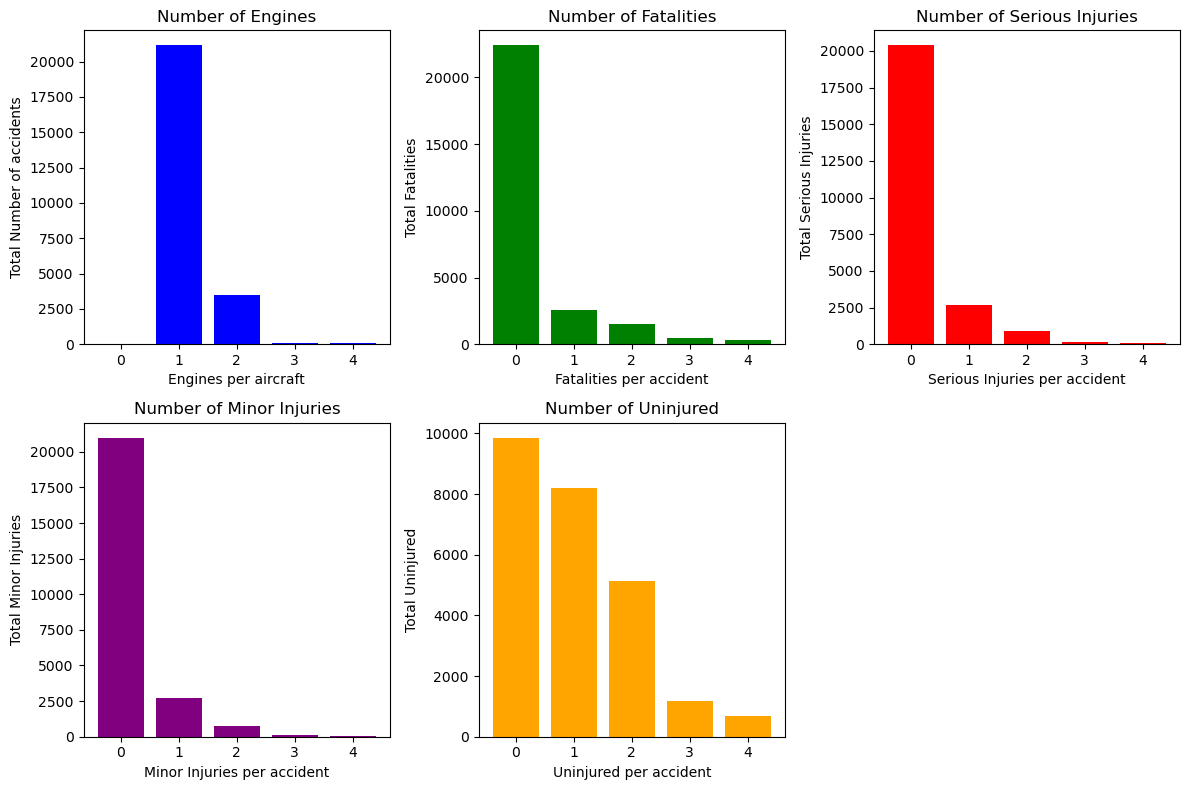

In [8]:
plt.figure(figsize=(12, 8))

# Engines
plt.subplot(2, 3, 1)
plt.bar(df['Engines'].value_counts().index[0:5], df['Engines'].value_counts().values[0:5], color='blue')
plt.title('Number of Engines')
plt.xlabel('Engines per aircraft')
plt.ylabel('Total Number of accidents')

# Fatalities
plt.subplot(2, 3, 2)
plt.bar(df['Fatal'].value_counts().index[0:5], df['Fatal'].value_counts().values[0:5], color='green')
plt.title('Number of Fatalities')
plt.xlabel('Fatalities per accident')
plt.ylabel('Total Fatalities')

# Serious
plt.subplot(2, 3, 3)
plt.bar(df['Serious'].value_counts().index[0:5], df['Serious'].value_counts().values[0:5], color='red')
plt.title('Number of Serious Injuries')
plt.xlabel('Serious Injuries per accident')
plt.ylabel('Total Serious Injuries')

# Minor
plt.subplot(2, 3, 4)
plt.bar(df['Minor'].value_counts().index[0:5], df['Minor'].value_counts().values[0:5], color='purple')
plt.title('Number of Minor Injuries')
plt.xlabel('Minor Injuries per accident')
plt.ylabel('Total Minor Injuries')

# Uninjured
plt.subplot(2, 3, 5)
plt.bar(df['Uninjured'].value_counts().index[0:5], df['Uninjured'].value_counts().values[0:5], color='orange')
plt.title('Number of Uninjured')
plt.xlabel('Uninjured per accident')
plt.ylabel('Total Uninjured')

# Save the figure into a subfolder
plt.savefig(f'images/NAN mean.png', transparent=True, bbox_inches='tight')

plt.tight_layout() 
plt.show()

Upon review of data, previous charts indicate very positively skewed charts. To update the values without changing the data drastically, the following columns will be updated with the median.

In [9]:
#based on chart data showing large positive skewing replacing NaN values for the following with median Value
df['Engines'].fillna(value = df['Engines'].median(), inplace = True)
df['Serious'].fillna(value = df['Serious'].median(), inplace = True)
df['Minor'].fillna(value = df['Minor'].median(), inplace = True)
df['Uninjured'].fillna(value = df['Uninjured'].median(), inplace = True)
df.isna().sum().max()

0

Now for determining best code to reduce duplicate `Make` and `Model` entries in the dataframe.

In [10]:
#Formating strings to make uniform for data cleaning.
df['Make'] = df['Make'].str.upper()
df['Model'] = df['Model'].str.upper()
print(len(df['Make'].unique()))
print(len(df['Model'].unique()))

3533
5068


Using value counts to replace `model` names with shorter value starting from the largest total in value count.

In [11]:
# Cleaning Make Column
# Droping rows with NA as the make. Only 1 row was droped.
df = df[df['Make'] != 'NA']
# Looping thru index to standardize names for 'Make'
# Following method will not work for models
for item in df['Make'].value_counts().index:
    df['Make'] = df['Make'].apply(lambda x: item if item in x else x)

Upon reviewing column values for `Make`, updating the following names

In [12]:
#Updating names in 'Make' for accuracy 
df['Make'] = df['Make'].apply(lambda x: 'DE HAVILLAND' if 'DEHAVILLAND' in x else x)
df['Make'] = df['Make'].apply(lambda x: 'AERO TECHNIK' if 'AEROTECHNIK' in x else x)

Upon reviewing the `Model` column, reduced repeated models by replacing `' '` with `'-'`. Then reviewing purpose value count for categories of flights to determine which types of flights apply for risk assessment. Also droping the `'Make'` E135-LEGACY. Data is outlier with 154 fatalities listed.

In [13]:
# Replacing ' ' with '-'
df['Model'] = df['Model'].str.replace(' ', '-')

# Droping model E135-LEGACY due to being outlier
df  = df[df['Model'] != 'E135-LEGACY']
df['Purpose'].value_counts()

Purpose
Personal                     16138
Unknown                       4588
Instructional                 3211
Aerial Application            1066
Business                       784
Positioning                    358
Flight Test                    226
Ferry                          175
Aerial Observation             170
Skydiving                      166
Other Work Use                 158
Executive/corporate            151
Banner Tow                      89
Air Race show                   74
Public Aircraft - Federal       53
Public Aircraft                 43
Glider Tow                      35
Public Aircraft - State         24
Firefighting                    17
Public Aircraft - Local         12
Air Race/show                    7
ASHO                             6
Air Drop                         3
PUBS                             3
External Load                    1
Name: count, dtype: int64

### Question 1
#### What types of flights have the highest average fatalities?
---

To answer our first problem we will calculate the mean for fatalities for each purpose in the purpose column. This will help later with our data analysis and show us some good starting data for what type of business would have the most/least risk of fatalities.

#### Data Analysis
---

To answer our first problem we will calculate the mean for fatalities for each purpose in the purpose column. This will help later with our data analysis and show us some good starting data for what type of business would have the most/least risk of fatalities.

In [14]:
# Calculate mean of 'Fatal' for each 'Purpose' category
mean_fatal_df = df.groupby('Purpose')['Fatal'].mean()

# # Convert Series to DataFrame
mean_fatal_df = mean_fatal_df.reset_index()

mean_fatal_df.columns = ['Purpose', 'Mean Fatal']

# Round 'Mean Fatal' to 2 decimal points
mean_fatal_df['Mean Fatal'] = mean_fatal_df['Mean Fatal'].round(3)

# # Sort DataFrame in descending order by 'Mean Fatal' and reset index
mean_fatal_df = mean_fatal_df.sort_values(by='Mean Fatal', ascending=False).reset_index(drop=True)

mean_fatal_df.head()

,Purpose,Mean Fatal
0,ASHO,2.333
1,Unknown,1.859
2,Skydiving,1.307
3,Public Aircraft,1.070
4,Firefighting,0.765


Droping purpose values that are not business related and plotting results. This will allow us to show what categories of business have the least fatalities associated with that business type.

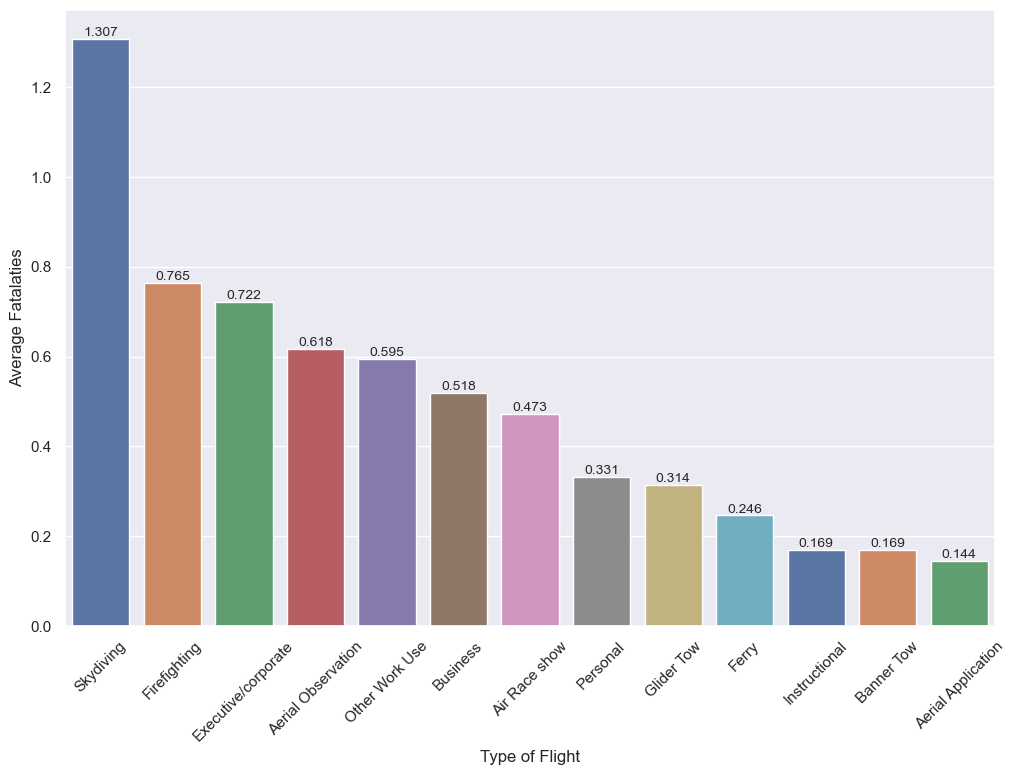

In [15]:
# List of purposes to drop
purposes_to_drop = ['Public Aircraft', 'External Load', 'PUBS', 'Air Drop', 'Public Aircraft - State', 
                    'Public Aircraft - Federal', 'Positioning', 'Air Race/show', 'Flight Test',  
                    'Public Aircraft - Local', 'Air Race show/Air Race/show', 'ASHO', 'Unknown']

# Drop the purposes
mean_fatal_df_plot = mean_fatal_df[~mean_fatal_df['Purpose'].isin(purposes_to_drop)]

# Set the style of the plot
sns.set(style="darkgrid")

# Create a bar plot
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='Purpose', y='Mean Fatal', data=mean_fatal_df_plot, palette="deep")

# Set the labels and title
bar_plot.set(xlabel='Type of Flight', ylabel='Average Fatalaties')
# plt.title('Average Fatalities by Flight Type', fontsize=20)

plt.xticks(rotation=45)

# Add labels to the top of each bar
for i, v in enumerate(mean_fatal_df_plot['Mean Fatal']):
    bar_plot.text(i, v, str(v), ha='center', va='bottom', fontsize=10)

# Rotate text by 45 degrees
plt.xticks(rotation=45)

# Save the figure into a subfolder
plt.savefig(f'images/MeanFatalByFlightType.png', transparent=True, bbox_inches='tight')

# Show the plot
plt.show()


Viewing  plotting results. This will allow us to show what categories of business have the least fatalities associated with that business type. After this plotting the results.

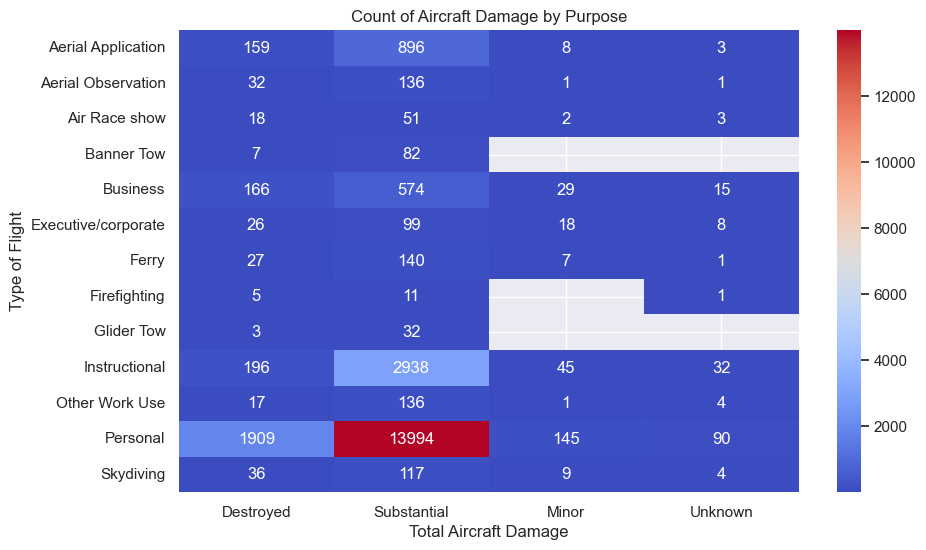

In [16]:
# Count the number of occurrences for each combination of 'Purpose' and 'Aircraft Damage'
damage_count_df = df.groupby(['Purpose', 'Aircraft Damage']).size().reset_index(name='Count')

# Drop the purposes
damage_count_df_plot = damage_count_df[~damage_count_df['Purpose'].isin(purposes_to_drop)]

# Pivot the DataFrame to prepare it for plotting
damage_count_pivot = damage_count_df_plot.pivot(index='Purpose', columns='Aircraft Damage', values='Count')

# Changing order for plot
damage_count_pivot = damage_count_pivot[['Destroyed', 'Substantial', 'Minor', 'Unknown']]

# Plot the data
plt.figure(figsize=(10, 6))
sns.heatmap(damage_count_pivot, annot=True, fmt=".0f", cmap='coolwarm')
plt.title('Count of Aircraft Damage by Purpose')
plt.xlabel('Total Aircraft Damage')
plt.ylabel('Type of Flight')

# Save the figure into a subfolder
plt.savefig(f'images/DamageByPurposeCount.png', transparent=True)
plt.show()

<Figure size 1200x800 with 0 Axes>

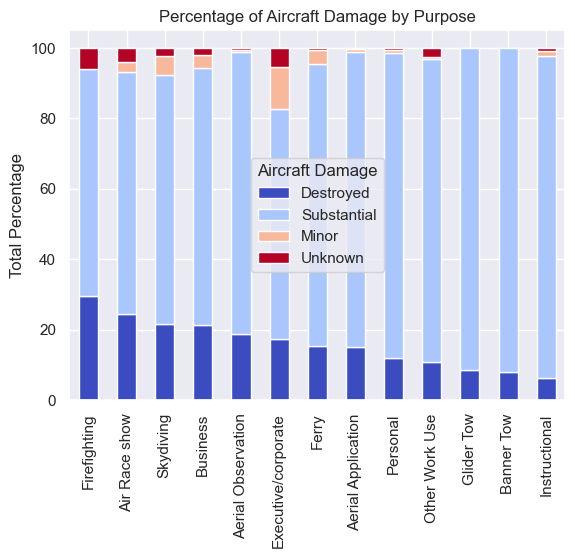

In [17]:
# Calculate the row sums
row_sums = damage_count_pivot.sum(axis=1)

# Divide each value by the row sum to get the percentage
damage_count_pivot_percentage = damage_count_pivot.div(row_sums, axis=0) * 100

# Sort the DataFrame by the 'Destroyed' column
damage_count_pivot_percentage = damage_count_pivot_percentage.sort_values('Destroyed', ascending=False)

# Sort the DataFrame by the 'Destroyed' column
damage_count_pivot_percentage.to_excel("data/damage percentages.xlsx")

# Plot the data
plt.figure(figsize=(12, 8))
damage_count_pivot_percentage.plot(kind='bar', stacked=True, cmap='coolwarm')

# Set the labels and title
plt.title('Percentage of Aircraft Damage by Purpose')
plt.xlabel('')
plt.ylabel('Total Percentage')
plt.legend(title='Aircraft Damage')

# Save the figure into a subfolder
plt.savefig(f'images/DamageByPurpose.png', transparent=True,  bbox_inches='tight')

# Show the plot
plt.show()


Adding Mean Fatal data to original dataframe to be used to answer later question.

In [18]:
# Create a mapping from 'Purpose' to 'Mean Fatal'
mapping = mean_fatal_df.set_index('Purpose')['Mean Fatal'].to_dict()

# Add 'Mean Fatal' column to df
df['Mean Fatal'] = df['Purpose'].map(mapping)
df['Mean Fatal'].head()

5     1.859
7     0.331
8     0.518
12    0.331
13    0.331
Name: Mean Fatal, dtype: float64

### Question 2
#### What effect on safety do engines have and how much is this effected by weather?
---

To answer our second question we will be looking at the percentages of accidents taking place for each weather category. We will also be plotting what number of engines is associated with these accidents.

#### Weather Information
---
Defining variables in data set for a better understanding of what condistions are stored in dataframe

**Instrument meteorological conditions (IMC)** 

- IMC refers to weather conditions that do not meet the criteria for Visual Meteorological Conditions. This means that the visibility and/or cloud clearance are below the minimum required for VMC.

- In IMC, pilots cannot adequately navigate or control the aircraft using visual references due to poor visibility or obscured horizon.

**Visual meteorological conditions (VMC)** 

- VMC refers to weather conditions in which pilots have sufficient visibility and reference to the ground or horizon to navigate and control the aircraft visually.

- When above 3,000ft or 1,000ft above terrain, whichever is higher:
        1500m horizontally and 1,000 ft vertically from cloud;
        Flight visibility 5km below 10,000ft and 8km above 10,000ft.
        
- When below 3,000ft or 1,000ft above terrain, whichever is higher:
         Clear of cloud and in sight of the surface;
         Flight visibility 5km.

In [19]:
engine_weather_df = df[df.Investigation == 'Accident']
engine_weather_df.Engines.value_counts()

Engines
1.0    22964
2.0     2853
4.0       52
3.0       30
0.0        8
8.0        1
6.0        1
Name: count, dtype: int64

Droping rows with less then 10 entries. To little data for proper analysis.

In [20]:
engine_weather_df = engine_weather_df[(engine_weather_df['Engines'] > 0) & (engine_weather_df['Engines'] < 5)]
engine_weather_df.Engines.value_counts()

Engines
1.0    22964
2.0     2853
4.0       52
3.0       30
Name: count, dtype: int64

#### Plotting Engine and Weather Information
---
Creating two plots to show th percentages of accidents that occure during each weather type, and how many engines for each of those weather types.

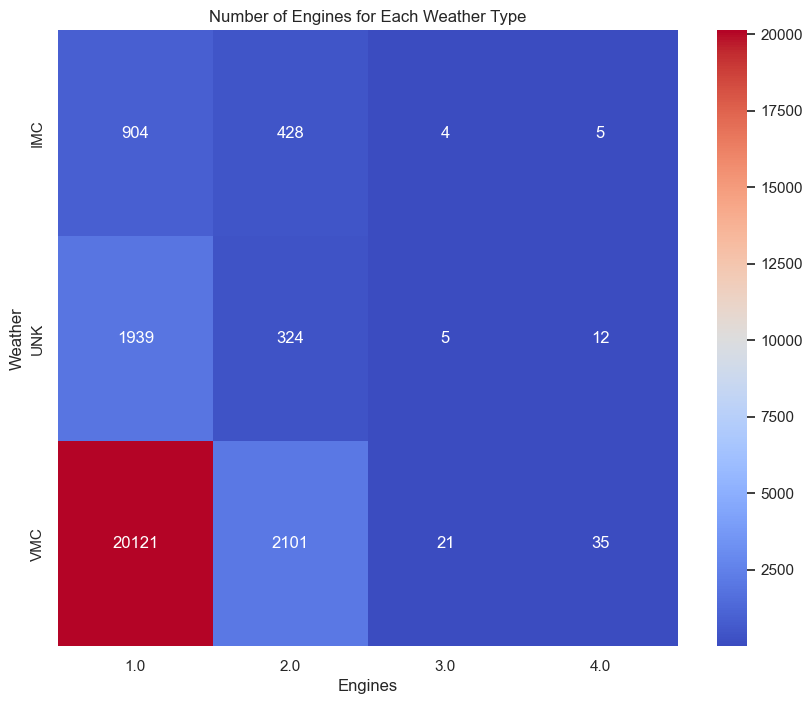

In [21]:
# Pivot the DataFrame
df_plot = engine_weather_df.pivot_table(index='Weather', columns='Engines', aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_plot, annot=True, fmt='d', cmap='coolwarm')
plt.title('Number of Engines for Each Weather Type')
# Save the figure into a subfolder
plt.savefig(f'images/EnginesWeatherHeatMap.png', transparent=True)
plt.show()

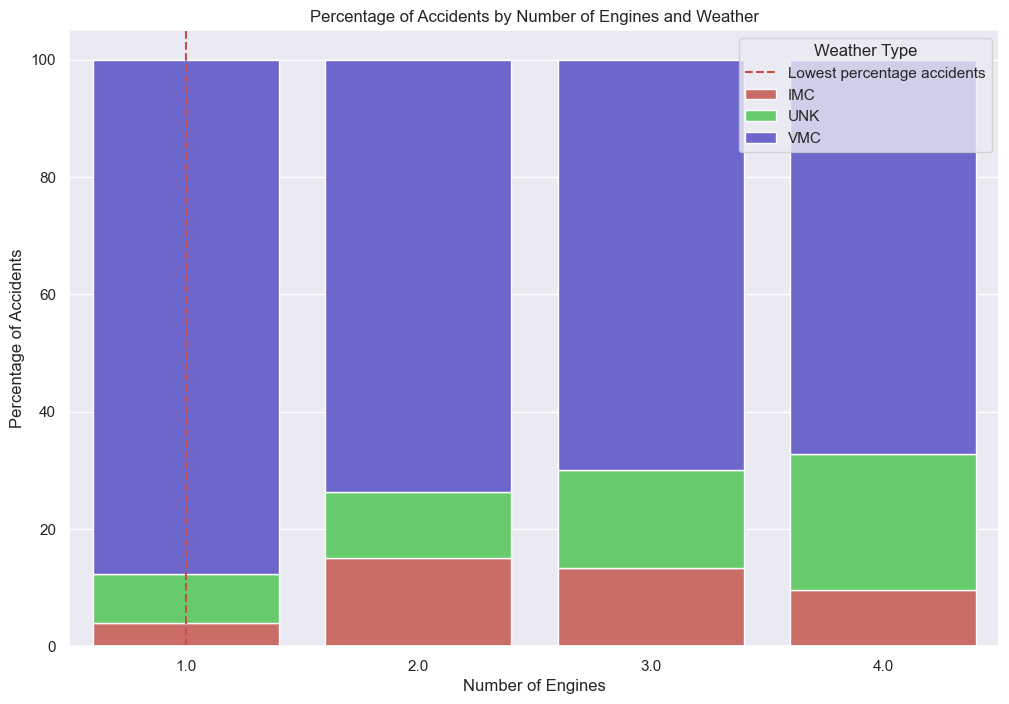

In [22]:
# Calculate the percentages
engine_weather_percentages = engine_weather_df.groupby('Engines')['Weather'].value_counts(normalize=True).unstack() * 100

# Get the list of weathers
weathers = engine_weather_percentages.columns

# Set the style of the plot
sns.set(style="darkgrid")

# Create a 100% stacked bar plot
plt.figure(figsize=(12, 8))

# Create a color palette
palette = sns.color_palette("hls", len(weathers))

# Create a bar plot for each weather
bottom = np.zeros(len(engine_weather_percentages))
for idx, weather in enumerate(weathers):
    sns.barplot(x=engine_weather_percentages.index, y=engine_weather_percentages[weather], label=weather, bottom=bottom, color=palette[idx])
    bottom += engine_weather_percentages[weather]

# Set the labels and title
plt.xlabel('Number of Engines')
plt.ylabel('Percentage of Accidents')
plt.title('Percentage of Accidents by Number of Engines and Weather')

# Add a vertical line to mark the column with the smallest IMC
plt.axvline(x=0, color='r', linestyle='--', label="Lowest percentage accidents")

# Add a legend
plt.legend(title='Weather Type')

# Save the figure into a subfolder
plt.savefig(f'images/WeatherType.png', transparent=True)

# Show the plot
plt.show()

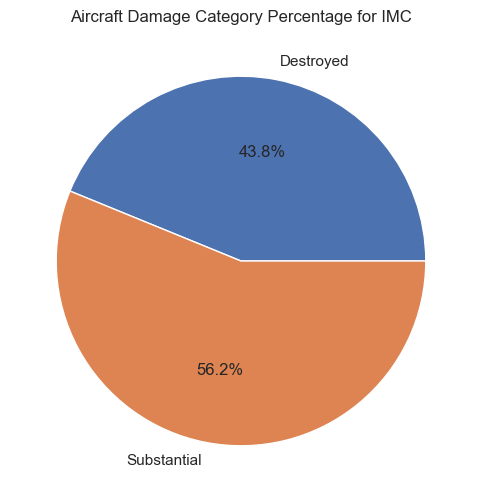

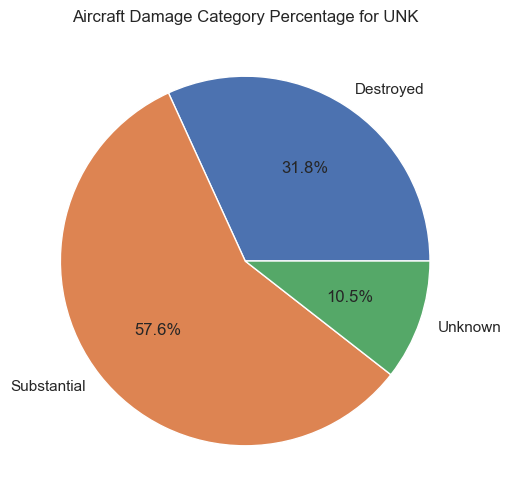

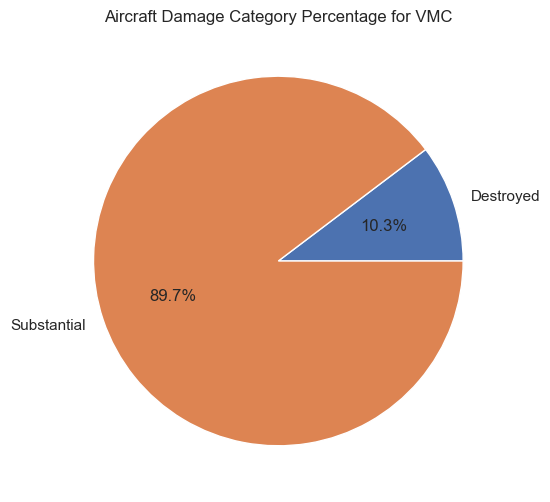

In [23]:
# Group by 'Weather Type' and 'Aircraft Damage' and count the number of occurrences
grouped_df = engine_weather_df.groupby(['Weather', 'Aircraft Damage']).size().reset_index(name='Counts')

# Calculate the percentage for each damage category within each weather type
grouped_df['Percentage'] = grouped_df.groupby('Weather')['Counts'].transform(lambda x: 100 * x / x.sum())

# Filter the dataframe to include only percentages over 5%
filtered_df = grouped_df[grouped_df['Percentage'] > 5]

# Get the unique weather types
weather_types = filtered_df['Weather'].unique()

# Plot a pie chart for each weather type
for weather in weather_types:
    temp_df = filtered_df[filtered_df['Weather'] == weather]
    plt.figure(figsize=(6, 6))
    plt.pie(temp_df['Percentage'], labels=temp_df['Aircraft Damage'], autopct='%1.1f%%')
    plt.title(f'Aircraft Damage Category Percentage for {weather}')
    # Save the figure into a subfolder
    plt.savefig(f'images/{weather}.png', transparent=True)
    
    plt.show()

### Question 3
#### Which make and models have the lowest risk for commercial ventures?
---

Now that we have gone thru alot of the data and determined most of the factors that affect safety. It is now time to put this information together and pruduce a list of low risk models for business ventures.

#### Severity rating 
---
We will be acheiving this risk assessment by using a Severity rating. Assigning weights to different factors associated with aviation accidents and incidents. 

Severity Index formula = (4 * Fatalities) + (3 * Serious Injuries) + (3 * Minor Injuries) + (Accident Severity Code) + (Engine Code) + (3 * Mean Fatal)

    Number of Fatalities (Weight: 4):
        Assign a weight of 4 to the number of fatalities in an accident. The rationale is that the loss of life is a critical measure of severity.

    Number of Serious Injuries (Weight: 3):
        Assign a weight of 3 to the number of serious injuries. While not as severe as fatalities, injuries contribute to the overall severity.

    Number of Minor Injuries (Weight: 2):
        Assign a weight of 2 to the number of minor injuries. Contribute to the overall severity of accident.

    Economic Loss:
        This is represented but the column Damage Code which has a value based on damage.

    Weather Safety:
        Assign a weight survivability in adverse weather conditions. This is represented by the column Engine Code based on previous data.

    Flight Purpose (Weight: 3):
        Assigning a weight based on the average fatalities per accident for given purpose.

In [24]:
# Removing 'Unknown' values from 'Aircraft Damage'
severity_rating_df = df[(df['Aircraft Damage'] != 'Unknown') & (df['Engines'] > 0) & (df['Engines'] < 5)]

# List of purposes to drop based on commercial use cases
purposes_to_drop = [
    'Public Aircraft', 'External Load', 'PUBS', 'Air Drop', 'Public Aircraft - State', 
    'Public Aircraft - Federal', 'Positioning', 'Air Race/show', 'Flight Test', 'Personal', 
    'Public Aircraft - Local', 'Air Race show/Air Race/show', 'ASHO', 'Unknown'
    ]

# Drop the purposes list from dataframe
severity_rating_df = severity_rating_df[~severity_rating_df['Purpose'].isin(purposes_to_drop)]

# Dict of Engine codes based on weather data
engine_code_dict = {1: 0, 2: 8, 3: 6, 4: 4}

# Creating new column for 'Engine Code' based on dict
severity_rating_df['Engine Code'] = severity_rating_df['Engines'].map(engine_code_dict)

#Creating Dict to assign damage code value for each severity of aircraft damage.
damage_codes = {
    'Substantial': 10,
    'Destroyed': 20,
    'Minor': 5
    }

# Mapping Dict to dataframe to create new column 'Damage Code'
severity_rating_df['Damage Code'] = severity_rating_df['Aircraft Damage'].map(damage_codes)   


# Applying formula for calculating Severity Rating
severity_rating_df['Accident Severity'] = (
    severity_rating_df['Fatal']*4
    + severity_rating_df['Serious']*3
    + severity_rating_df['Minor']*2
    + severity_rating_df['Damage Code']
    + severity_rating_df['Engine Code']
    + severity_rating_df['Mean Fatal']*3
)

# Saving dataframe
severity_rating_df.to_excel("data/data clean.xlsx")

# Reviewing Value Counts for purpose column
severity_rating_df['Purpose'].value_counts()

Purpose
Instructional          3178
Aerial Application     1062
Business                769
Ferry                   174
Aerial Observation      169
Skydiving               162
Other Work Use          154
Executive/corporate     143
Banner Tow               89
Air Race show            71
Glider Tow               35
Firefighting             16
Name: count, dtype: int64

Generating new dataframes to compute the mean of accident severity ratings. A higher mean would imply a greater severity per accident.

In [25]:
# Grouping dataframe and calculating Accident Severity mean
df_severity_mean_by_purpose = severity_rating_df.groupby(['Make', 'Model', 'Purpose'])['Accident Severity'].mean().reset_index()
df_severity_mean_by_purpose = df_severity_mean_by_purpose.sort_values(by='Accident Severity', ascending=False).reset_index()

Creating a new variable for the purpose of plotting data.

In [26]:
df_severity_plot = df_severity_mean_by_purpose
df_severity_plot.drop('index', axis=1, inplace=True)
df_severity_plot = df_severity_plot.set_index('Make')
df_severity_plot

,Model,Purpose,Accident Severity
Make,,,
LOCKHEED,"LEARSTAR,-L-18-56",Skydiving,81.921
BEECH,65,Skydiving,79.921
BOEING,B17,Other Work Use,66.785
BEECH,C-45H,Skydiving,62.921
PIPER,PA-31T2,Business,61.554
...,...,...,...
CIRRUS,SF50,Ferry,5.738
TTX AIR LLC,LANCAIR,Instructional,5.507
AVIAT,F150-M,Instructional,5.507


Creating tables to show recomendation based on average accident severity rating. One for Least risk and one for most risk.

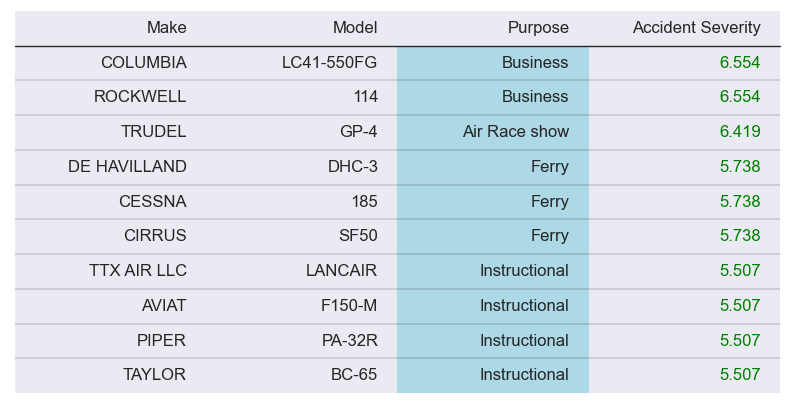

In [27]:
# Init a figure
fig, ax = plt.subplots(figsize=(10, 5))

# Round 'Accident Severity' to 3 decimal places
df_severity_plot['Accident Severity'] = df_severity_plot['Accident Severity'].round(3)

# Create the Table() object
tab = Table(df_severity_plot.tail(10))

# Change the color
tab.columns['Purpose'].set_facecolor("lightblue")
tab.columns['Accident Severity'].set_fontcolor("green")

# Save the figure into a subfolder
plt.savefig('images/Bottom10.png', transparent=True)

# Display the output
plt.show()

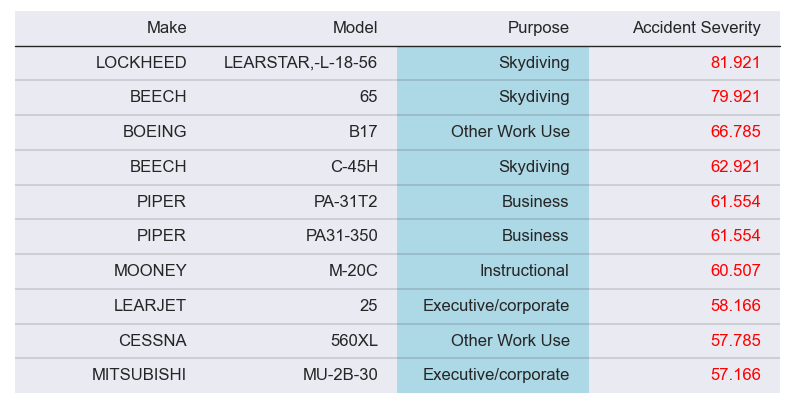

In [28]:
# Init a figure
fig, ax = plt.subplots(figsize=(10, 5))

# Round 'Accident Severity' to 3 decimal places
df_severity_plot['Accident Severity'] = df_severity_plot['Accident Severity'].round(3)

# Create the Table() object
tab = Table(df_severity_plot.head(10))
    
# Change the color
tab.columns['Purpose'].set_facecolor("lightblue")
tab.columns['Accident Severity'].set_fontcolor("red")

# Save the figure into a subfolder
plt.savefig('images/Top10.png', transparent=True)

# Display the output
plt.show()

# Conclusion

### Goal 1
---
Based on the data, skydiving, firefighting, and executive flights show the highest risk of fatalities, while instructional, banner tow, and aerial application activities demonstrate the least risk. The higher risk in the former activities aligns with their inherent dangers. Regarding aircraft damage, the findings correlate with fatalities except for air races. This deviation is understandable as these aircraft likely incorporate more safety features aimed at reducing fatalities.

#### Goal 2
---
The data suggests that a single-engine setup might be more conducive to surviving adverse weather conditions. The larger volume of data for single-engine aircraft likely contributes to its higher accuracy. However, more data is needed for multi-engine aircraft, especially for understanding their performance in adverse weather. Additionally, exploring the use cases for larger engine aircraft would provide valuable insights.

#### Goal 3
---
Utilizing a severity rating proved highly effective in consolidating the data into a numerical format. The amalgamation of data from our earlier objectives yielded valuable insights. Based on this analysis, we've formulated recommendations for 10 Make and Model combinations, each associated with a specific type of business.

#### Data Analysis 
---
While this data proved invaluable for analyzing aviation accidents and gaining insights, a more comprehensive set of information is necessary to offer a robust recommendation for a business model. This additional data would encompass the total number of flights for each model, the cost of damages for repair, and the intended locations for business initiation. Despite this need for further details, the gleaned data remains highly beneficial, allowing for valuable recommendations in establishing low-risk aviation businesses.